# **Movie Recommendition System**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer
from surprise import Dataset, Reader, SVD
from surprise.model_selection import cross_validate, train_test_split
from surprise import accuracy

import warnings
warnings.filterwarnings('ignore')

# **Datasets Overview**

### **1) Ratings Dataset**

- All ratings are contained in the file `ratings.csv`. Each line of this file after the header row represents one rating of one movie by one user, and has attributes (userId, movieId, rating, timestamp).

- The lines within this file are ordered first by userId, then, within user, by movieId.

**NOTE** :Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).

### **2) Movies Dataset**

- Movie information is contained in the file `movies.csv`. Each line of this file after the header row represents one movie, and has attributes (movieId, title, genres)

- Genres are a pipe-separated list, and are selected from the following: (Action, Adventure, Animation, Children's, Comedy, Crime, Documentary, Drama, Fantasy, Film-Noir, Horror, Musical, Mystery, Romance, Sci-Fi, Thriller, War, Western, no genres listed).


### **3) Links Dataset**

- All links are contained in the file `links.csv` with attributes (movieId, imdbId, tmdbId)

- movieId is an identifier for movies used by <https://movielens.org>.

- imdbId is an identifier for movies used by <http://www.imdb.com>.

- tmdbId is an identifier for movies used by <https://www.themoviedb.org>.

### **4) Tags Dataset**

- All tags are contained in the file `tags.csv`. Each line of this file after the header row represents one tag applied to one movie by one user, and has attributes (userId, movieId, tag, timestamp).

In [ ]:
ratings = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')
links = pd.read_csv('ml-latest-small/links.csv')
tags = pd.read_csv('ml-latest-small/tags.csv')

# **Data Preprocessing**

## **Check Null Values**

In [ ]:
print(ratings.isnull().sum())
print(movies.isnull().sum())
print(tags.isnull().sum())
print(links.isnull().sum())

userId       0
movieId      0
rating       0
timestamp    0
dtype: int64
movieId    0
title      0
genres     0
dtype: int64
userId       0
movieId      0
tag          0
timestamp    0
dtype: int64
movieId    0
imdbId     0
tmdbId     8
dtype: int64


In [ ]:
links.isnull().sum() #8 nulls
# each movie is exactly mentioned one time and some doesnt have tmbid

,0
movieId,0
imdbId,0
tmdbId,8


In [ ]:
# find nulls
rows_with_nulls = links[links.isnull().any(axis=1)]
print(rows_with_nulls)
# 791  , 1107  ,2851   ,4051   ,26587   ,32600  ,40697  ,79299

      movieId  imdbId  tmdbId
624       791  113610     NaN
843      1107  102336     NaN
2141     2851   81454     NaN
3027     4051   56600     NaN
5532    26587   92337     NaN
5854    32600  377059     NaN
6059    40697  105946     NaN
7382    79299  874957     NaN


In [ ]:
# manually add tmdb for each missing movie (8 movies only so either drop or fill we cant fill with mean or mode because it is ID so drop or put right ID)
moviecheck = movies[movies['movieId']==791]
moviecheck = movies[movies['movieId']==1107]#not found in tmdb i think i will drop it from all pandas(dropped)
moviecheck = movies[movies['movieId']==2851]
moviecheck = movies[movies['movieId']==4051]
moviecheck = movies[movies['movieId']==26587]
moviecheck = movies[movies['movieId']==32600]
moviecheck = movies[movies['movieId']==40697]
moviecheck = movies[movies['movieId']==79299]
linkscheck =links[links['movieId']==2851]
linkscheck =links[links['movieId']==4051]
linkscheck =links[links['movieId']==26587]
linkscheck =links[links['movieId']==32600]
linkscheck =links[links['movieId']==40697]
linkscheck =links[links['movieId']==79299]
# links['tmdbId']
links.loc[links['movieId'] == 791, 'tmdbId'] = 706007
links.loc[links['movieId'] == 2851, 'tmdbId'] = 19761
links.loc[links['movieId'] == 4051, 'tmdbId'] = 31392
links.loc[links['movieId'] == 26587, 'tmdbId'] = 118667
links.loc[links['movieId'] == 32600, 'tmdbId'] = 39850
links.loc[links['movieId'] == 40697, 'tmdbId'] = 3137
links.loc[links['movieId'] == 79299, 'tmdbId'] = 7154

In [ ]:
# can't fill this movie so drop it
movies = movies.drop(movies[movies['movieId']==1107].index)
ratings =ratings.drop(ratings[ratings['movieId']==1107].index)
links = links.drop(links[links['movieId']==1107].index)
tags=tags.drop(tags[tags['movieId']==1107].index)

links.isnull().sum()

,0
movieId,0
imdbId,0
tmdbId,0


## **Explore Data Statistics**

In [ ]:
print(ratings.describe())
print(movies.describe())
print(tags.describe())
print(links.describe())

              userId        movieId         rating     timestamp
count  100834.000000  100834.000000  100834.000000  1.008340e+05
mean      326.129490   19435.659252       3.501587  1.205945e+09
std       182.619532   35531.245807       1.042497  2.162611e+08
min         1.000000       1.000000       0.500000  8.281246e+08
25%       177.000000    1199.000000       3.000000  1.019124e+09
50%       325.000000    2991.000000       3.500000  1.186087e+09
75%       477.000000    8124.000000       4.000000  1.435994e+09
max       610.000000  193609.000000       5.000000  1.537799e+09
             movieId
count    9741.000000
mean    42204.572221
std     52161.510388
min         1.000000
25%      3249.000000
50%      7301.000000
75%     76251.000000
max    193609.000000
            userId        movieId     timestamp
count  3683.000000    3683.000000  3.683000e+03
mean    431.149335   27252.013576  1.320032e+09
std     158.472553   43490.558803  1.721025e+08
min       2.000000       1.000000 

### **Insights**

- **Ratings Distribution:** The average rating is near 3.5, which shows that most ratings are centered around the middle of the rating scale, suggesting users tend to rate movies somewhat moderately rather than very highly or very low.

- **Number of Ratings:** There is a significant number of ratings from users (100,834 ratings), but this might not be uniformly distributed, meaning some movies may be overrepresented while others are not rated as much.

- **Movie and Tag Diversity:** The movies dataset has a large range of movie IDs (1 to 193,609), which shows the diversity of movies in the dataset. The tags dataset has fewer interactions compared to ratings, but the users tagging movies are not the same as those rating movies.

## **Movies' Title & Genre Processing**

In [ ]:
# movies
movies['genres'] = movies['genres'].str.split('|') #split genres
# removed most common special characters from title
movies['title'] = movies['title'].str.strip().str.lower()
movies['title'] = movies['title'].astype(str).str.replace(r'\(.*?\)', '', regex=True).str.replace(r':', '').str.replace(r';', '').str.replace(r'|', '').str.strip()
movies['title'].head()
movies

,movieId,title,genres
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,jumanji,"[Adventure, Children, Fantasy]"
2,3,grumpier old men,"[Comedy, Romance]"
3,4,waiting to exhale,"[Comedy, Drama, Romance]"
4,5,father of the bride part ii,[Comedy]
...,...,...,...
9737,193581,black butler book of the atlantic,"[Action, Animation, Comedy, Fantasy]"
9738,193583,no game no life zero,"[Animation, Comedy, Fantasy]"
9739,193585,flint,[Drama]
9740,193587,bungo stray dogs dead apple,"[Action, Animation]"


## **Datatype Fixing**

In [ ]:
# timestamp is datetime
ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s')
# remove outliers
ratings = ratings[ratings['rating'] >= 0.5]
ratings = ratings[ratings['rating'] <= 5.0]
ratings.drop_duplicates(inplace=True)

In [ ]:
# tags
tags['timestamp'] = pd.to_datetime(tags['timestamp'], unit='s')

In [ ]:
# links
links = links[links['movieId'].isin(movies['movieId'])]#makes sure that links are in movies not only dummy link

## **Merge Necessary Datasets**

In [ ]:
# merging for better use
merged_movies_rating = pd.merge(ratings, movies, on='movieId')

genres_expanded = movies.explode('genres')
# Merge the genres with the ratings data
merged_genre_ratings = pd.merge(ratings, genres_expanded[['movieId', 'genres']], on='movieId')

# **EDA & Data Visualization**

## **Ratings Distribution**

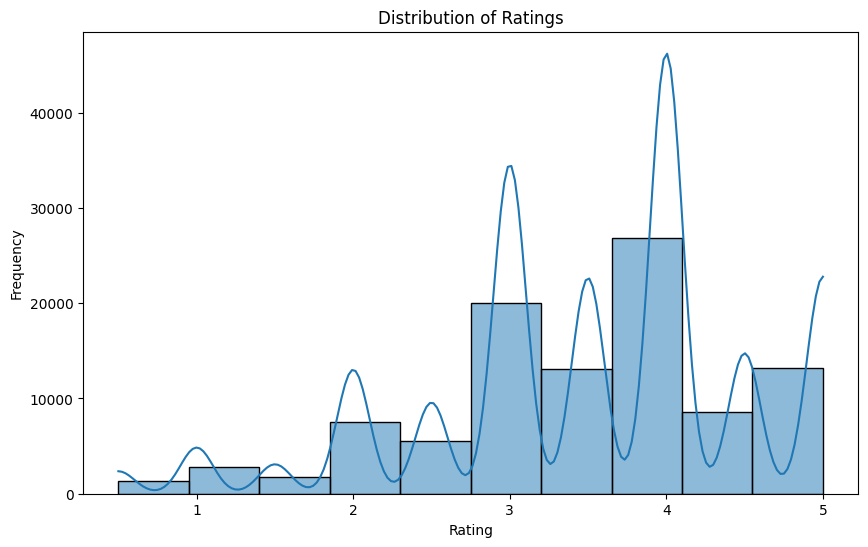

In [ ]:
# Plot distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(ratings['rating'], bins=10, kde=True)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

**Insights**

people tend to rate **4 stars** more that might mean they like the movie but it's not their favorite also they rate 3 by huge amount maybe it means that the movie is neither good nor bad.


## **Top 10 Movies by Ratings**

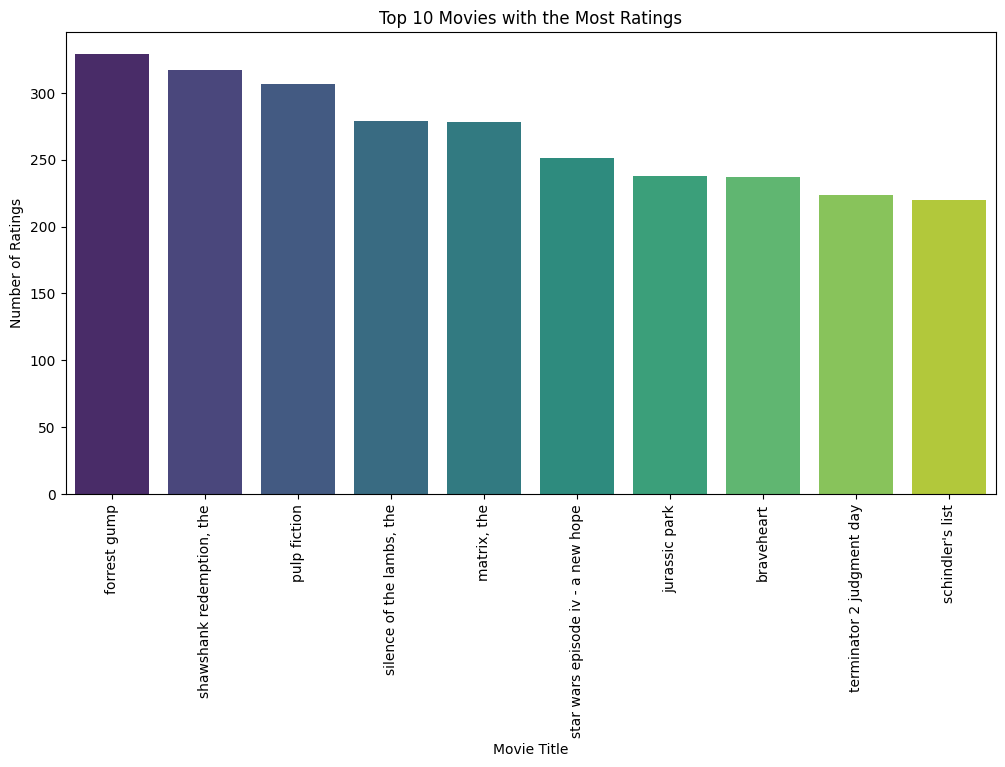

In [ ]:
# Count of ratings for each movie
movie_ratings_count = merged_movies_rating.groupby('title')['rating'].count()
movie_ratings_count = movie_ratings_count.sort_values(ascending=False)

# Top 10 movies with the most ratings
top_rated_movies = movie_ratings_count.head(10)

# Plot the top 10 movies by title
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_movies.index, y=top_rated_movies.values, palette='viridis')
plt.title('Top 10 Movies with the Most Ratings')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=90)
plt.show()

## **Average Rating for Top 10 Movies**

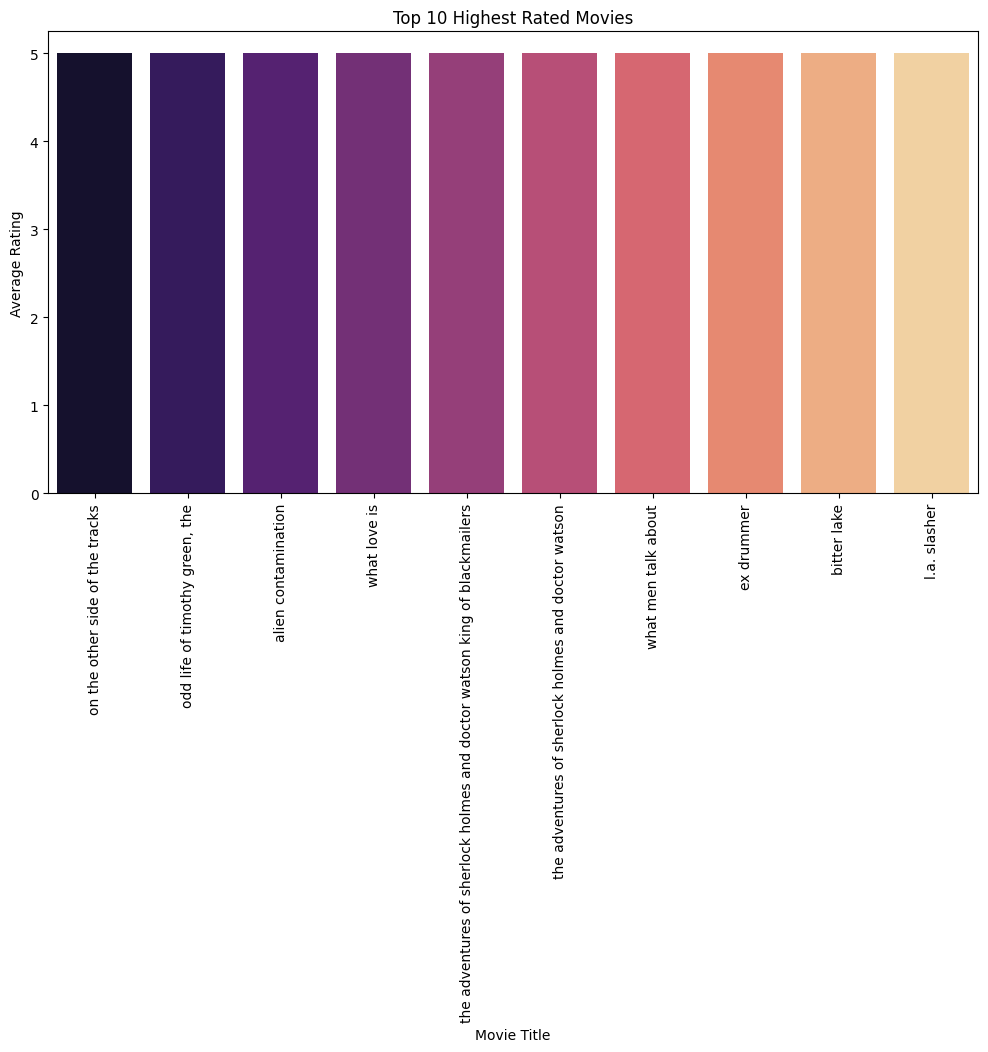

In [ ]:
# Calculate average rating by movie
average_ratings = merged_movies_rating.groupby('title')['rating'].mean()
average_ratings = average_ratings.sort_values(ascending=False)

# Top 10 highest rated movies
top_avg_rated_movies = average_ratings.head(10)

# Plot the top 10 highest rated movies by title
plt.figure(figsize=(12, 6))
sns.barplot(x=top_avg_rated_movies.index, y=top_avg_rated_movies.values, palette='magma')
plt.title('Top 10 Highest Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Average Rating')
plt.xticks(rotation=90)
plt.show()

**Insights**

there are **more drama movies** than musical or war maybe the cost of drama movies production is less than musical or war :)

## **Genre Distibution**

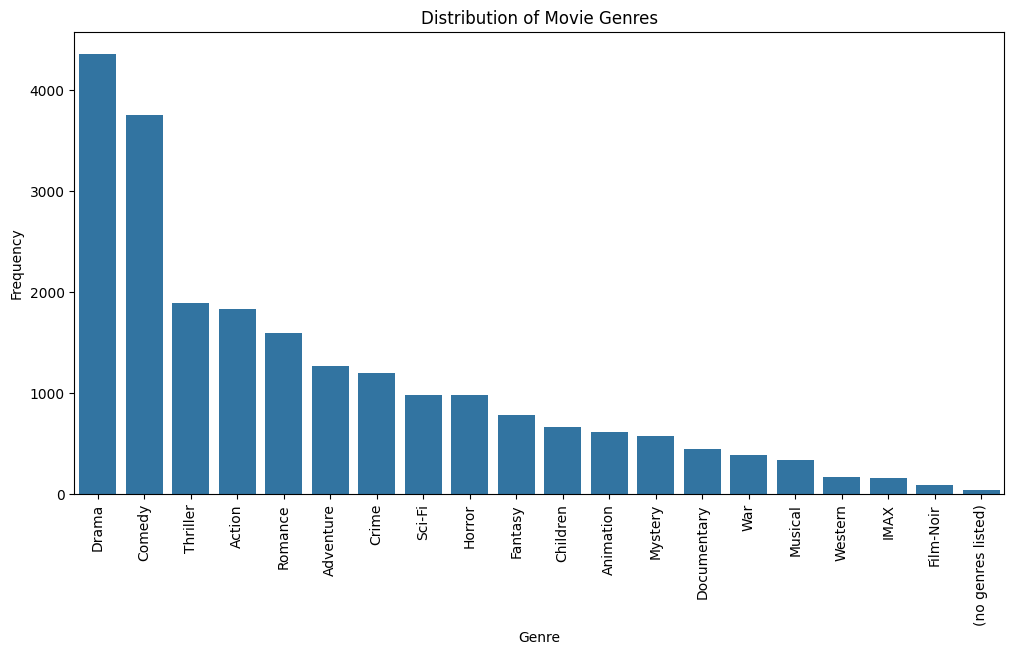

In [ ]:
# Split genres into individual genres
genre_list = [genre for sublist in movies['genres'] for genre in sublist]
genre_count = pd.Series(genre_list).value_counts()

# Plot genre distribution
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_count.index, y=genre_count.values)
plt.title('Distribution of Movie Genres')
plt.xlabel('Genre')
plt.ylabel('Frequency')
plt.xticks(rotation=90)
plt.show()

**Insights**

- users tends to rate drama more.
- chlidren genre are less rated.

## **Top 10 Genres by Number of Ratings**

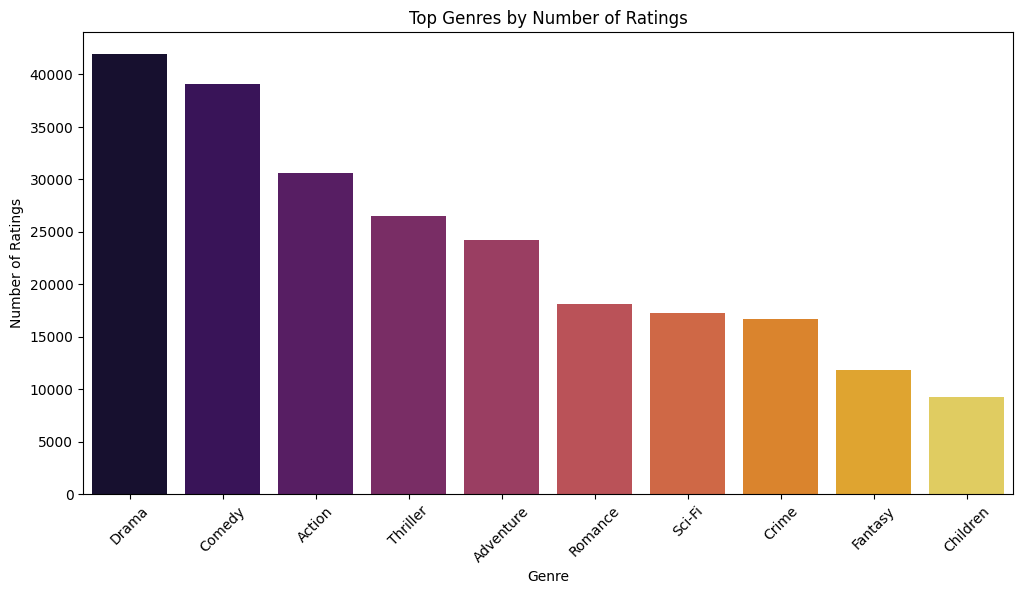

In [ ]:
genre_ratings_count = merged_genre_ratings.groupby('genres')['rating'].count()
genre_ratings_count = genre_ratings_count.sort_values(ascending=False)

# Top 10 genres by number of ratings
top_genre_ratings_count = genre_ratings_count.head(10)

# Plot the number of ratings per genre
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genre_ratings_count.index, y=top_genre_ratings_count.values, palette='inferno')
plt.title('Top Genres by Number of Ratings')
plt.xlabel('Genre')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.show()

**Insights**

the avg rating per genre are close but people tend to rate horror movies less , also comedy maybe it wasn't funny to them. those feelings are relative so avg rating are less.


## **Top Genres by Average Rating**

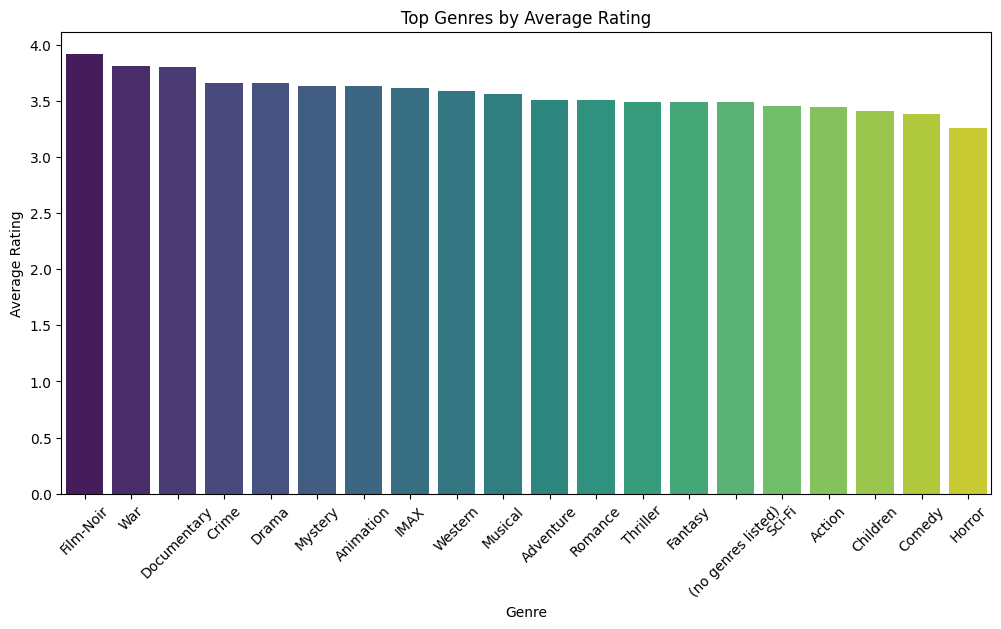

In [ ]:
genre_avg_rating = merged_genre_ratings.groupby('genres')['rating'].mean()

# Sort genres by average rating
genre_avg_rating = genre_avg_rating.sort_values(ascending=False)

# Top genres by average rating
top_genre_avg_rating = genre_avg_rating.head(20)

# Plot the average rating per genre
plt.figure(figsize=(12, 6))
sns.barplot(x=top_genre_avg_rating.index, y=top_genre_avg_rating.values, palette='viridis')
plt.title('Top Genres by Average Rating')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()

## **Top 10 Users by Number of Ratings**

In [ ]:
# Count of ratings by user
user_ratings_count = ratings.groupby('userId')['rating'].count()
user_ratings_count = user_ratings_count.sort_values(ascending=False)

# Top 10 users with the most ratings
top_rated_users = user_ratings_count.head(20)
print(top_rated_users)

userId
414    2698
599    2478
474    2108
448    1864
274    1346
610    1302
68     1260
380    1218
606    1115
288    1055
249    1046
387    1027
182     977
307     975
603     943
298     938
177     904
318     879
232     862
480     836
Name: rating, dtype: int64


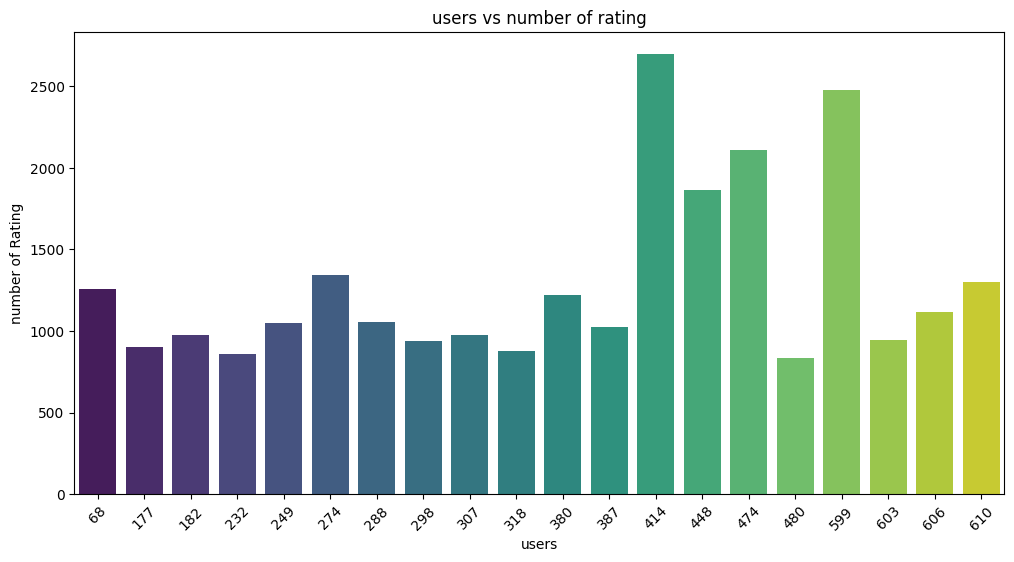

In [ ]:
plt.figure(figsize=(12, 6))
sns.barplot(x=top_rated_users.index, y=top_rated_users.values, palette='viridis')
plt.title('users vs number of rating')
plt.xlabel('users')
plt.ylabel('number of Rating')
plt.xticks(rotation=45)
plt.show()

**Insights**

users who tends to rate usually rates / watches more movies.

## **Popular Tags**

In [ ]:
# Count the occurrences of each tag
tag_count = tags['tag'].value_counts()

# Top 10 most popular tags
print(tag_count.head(20))

tag
In Netflix queue      131
atmospheric            36
thought-provoking      24
superhero              24
funny                  23
surreal                23
Disney                 23
religion               22
sci-fi                 21
quirky                 21
dark comedy            21
psychology             21
suspense               20
twist ending           19
visually appealing     19
crime                  19
politics               18
mental illness         16
music                  16
time travel            16
Name: count, dtype: int64


**Insights**

- **Popular Themes**: Tags like "In Netflix queue", "atmospheric", and "thought-provoking" are applied relatively frequently, indicating that these themes resonate strongly with the users. These themes are likely indicative of movies or shows that are trending or have drawn the attention of users.


- **Engagement vs. Popularity**: Tags like "In Netflix queue" (with 131 occurrences) could reflect how users queue up or bookmark movies they plan to watch in the future, showing a proactive interest in content, not just past viewing behavior.

# **Collaborative Filtering**

## **1) User-Based**

In [ ]:
# Create a user-movie rating matrix
merged_movies_rating = merged_movies_rating.drop_duplicates(['userId', 'title'])
user_movie_matrix = merged_movies_rating.pivot(index='userId', columns='movieId', values='rating').fillna(0)

In [ ]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_movie_matrix)
user_similarity_df = pd.DataFrame(user_similarity, index=user_movie_matrix.index, columns=user_movie_matrix.index)
user_similarity_df.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027418,0.060016,0.188687,0.129720,0.128787,0.159575,0.137647,0.064582,0.016959,...,0.080953,0.165270,0.220856,0.071019,0.155068,0.165895,0.270725,0.294087,0.094036,0.145000
2,0.027418,1.000000,0.000000,0.003726,0.016614,0.025333,0.027593,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.012017,0.000000,0.000000,0.028582,0.012948,0.046455,0.027565,0.102614
3,0.060016,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.025033,0.000000,0.010741,0.013063,0.019247,0.021240,0.000000,0.032177
4,0.188687,0.003726,0.002251,1.000000,0.128659,0.088491,0.115151,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.308489,0.052985,0.084957,0.201475,0.131746,0.150650,0.032198,0.107880
5,0.129720,0.016614,0.005020,0.128659,1.000000,0.300349,0.108371,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110332,0.258773,0.149414,0.107009,0.152866,0.136252,0.261232,0.060903


In [ ]:
# Extract movie Titles
movie_titles = merged_movies_rating.drop_duplicates(subset=['movieId']).set_index('movieId')['title'].to_dict()

In [ ]:
def get_recommendations(user_id, user_similarity_df, user_movie_matrix, movie_titles, top_n=5):

    # Get the similarity scores for the user
    sim_scores = user_similarity_df[user_id]
    # Sort users based on similarity scores
    sim_scores = sim_scores.sort_values(ascending=False)
    # Get top N most similar users
    top_users = sim_scores.iloc[1:top_n+1].index

    # Get movies rated by the top similar users
    recommended_movies = user_movie_matrix.loc[top_users].mean(axis=0)
    # Sort the movies by average rating
    recommended_movies = recommended_movies.sort_values(ascending=False)

    # Exclude movies already rated by the user
    user_rated_movies = user_movie_matrix.loc[user_id]
    recommended_movies = recommended_movies[user_rated_movies == 0]

    # Get the top recommended movies
    recommended_movie_ids = recommended_movies.index.tolist()
    # Map movie IDs to movie titles
    recommended_movie_titles = [movie_titles.get(movie_id, f"Unknown Movie (ID: {movie_id})") for movie_id in recommended_movie_ids]

    return recommended_movie_titles

In [ ]:
# Example: Get recommendations for user 1
user_id = 1
recommendations = get_recommendations(user_id, user_similarity_df, user_movie_matrix, movie_titles)
print(f"Top 5 Recommended movies for user {user_id}:")
recommendations[:5]

Top 5 Recommended movies for user 1:


['aliens',
 'hunt for red october, the',
 'blade runner',
 'godfather, the',
 'terminator 2 judgment day']

In [ ]:
# Example: Get recommendations for user 5
user_id = 5
recommendations = get_recommendations(user_id, user_similarity_df, user_movie_matrix, movie_titles)
print(f"Top 5 Recommended movies for user {user_id}:")
recommendations[:5]

Top 5 Recommended movies for user 5:


['forrest gump',
 'speed',
 'sleepless in seattle',
 'jurassic park',
 'silence of the lambs, the']

## **Item-Based**

In [ ]:
# Create a pivot table with users as rows and movies as columns
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Calculate cosine similarity between items
item_similarity = cosine_similarity(user_item_matrix.T)
item_similarity_df = pd.DataFrame(item_similarity, index=user_item_matrix.columns, columns=user_item_matrix.columns)

In [ ]:
# Function to recommend movies based on item similarity
def recommend_item_based(user_id, user_item_matrix, item_similarity_df, top_n=5):
    user_ratings = user_item_matrix.loc[user_id]
    user_rated_items = user_ratings[user_ratings > 0].index

    # Compute scores for all items
    scores = item_similarity_df[user_rated_items].dot(user_ratings[user_rated_items])
    scores = scores[~scores.index.isin(user_rated_items)]  # Exclude already rated items

    return scores

In [ ]:
# Example: Recommend movies for user 1
user_id = 1
print("Collaborative Filtering Recommendations:")
recommendations_id = recommend_item_based(user_id, user_item_matrix, item_similarity_df)
# Get the top recommended movies
recommended_movie_ids = recommendations_id.index.tolist()
# Map movie IDs to movie titles
recommended_movie_titles = [movie_titles.get(movie_id, f"Unknown Movie (ID: {movie_id})") for movie_id in recommended_movie_ids]
recommended_movie_titles[:5]

Collaborative Filtering Recommendations:


['jumanji',
 'waiting to exhale',
 'father of the bride part ii',
 'sabrina',
 'tom and huck']

In [ ]:
# Example: Recommend movies for user 5
user_id = 5
print("Collaborative Filtering Recommendations:")
recommendations_id = recommend_item_based(user_id, user_item_matrix, item_similarity_df)
# Get the top recommended movies
recommended_movie_ids = recommendations_id.index.tolist()
# Map movie IDs to movie titles
recommended_movie_titles = [movie_titles.get(movie_id, f"Unknown Movie (ID: {movie_id})") for movie_id in recommended_movie_ids]
recommended_movie_titles[:5]

Collaborative Filtering Recommendations:


['jumanji',
 'grumpier old men',
 'waiting to exhale',
 'father of the bride part ii',
 'heat']

# **Content-Based Filtering**

**Group Tags by Movie**


In [ ]:
# We combine tags for each movie into a single string. It groups all tags related to the same movie and joins them together.
# Then, the tags are merged with the movie information, and any missing tags are replaced with an empty string.

# Group tags by movieId and concatenate
tags_grouped = tags.groupby('movieId')['tag'].apply(lambda x: ' '.join(x)).reset_index()

# Merge grouped tags with movies data
movies_with_tags = movies.merge(tags_grouped, on='movieId', how='left')
# Fill missing tags with an empty string
movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')

**Combine Genres and Tags**

In [ ]:
# We combine the movie genres and tags into a new column called features. This helps represent each movie by both its genre and associated tags.
# Fill NaN values with an empty string to avoid issues during concatenation
movies_with_tags['tag'] = movies_with_tags['tag'].fillna('')
movies_with_tags['features'] = movies_with_tags['genres'].astype(str) + ' ' + movies_with_tags['tag'].astype(str)

# Display the updated DataFrame
movies_with_tags

,movieId,title,genres,tag,features
0,1,toy story,"[Adventure, Animation, Children, Comedy, Fantasy]",pixar pixar fun,"['Adventure', 'Animation', 'Children', 'Comedy..."
1,2,jumanji,"[Adventure, Children, Fantasy]",fantasy magic board game Robin Williams game,"['Adventure', 'Children', 'Fantasy'] fantasy m..."
2,3,grumpier old men,"[Comedy, Romance]",moldy old,"['Comedy', 'Romance'] moldy old"
3,4,waiting to exhale,"[Comedy, Drama, Romance]",,"['Comedy', 'Drama', 'Romance']"
4,5,father of the bride part ii,[Comedy],pregnancy remake,['Comedy'] pregnancy remake
...,...,...,...,...,...
9736,193581,black butler book of the atlantic,"[Action, Animation, Comedy, Fantasy]",,"['Action', 'Animation', 'Comedy', 'Fantasy']"
9737,193583,no game no life zero,"[Animation, Comedy, Fantasy]",,"['Animation', 'Comedy', 'Fantasy']"
9738,193585,flint,[Drama],,['Drama']
9739,193587,bungo stray dogs dead apple,"[Action, Animation]",,"['Action', 'Animation']"


**Convert Text Data into Numerical Features (TF-IDF)**

In [ ]:
# It creates a matrix where each movie is represented by the importance of the words (genres and tags) used to describe it.
# Initialize the TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

# Fit and transform the 'features' column
tfidf_matrix = tfidf_vectorizer.fit_transform(movies_with_tags['features'])

# Check the shape of the resulting TF-IDF matrix
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}") # rows correspond to movies and columns correspond to unique words in the features column.

TF-IDF matrix shape: (9741, 1677)


In [ ]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Print the first 10 feature names
print(feature_names[:100])

['06' '1900s' '1920s' '1950s' '1960s' '1970s' '1980s' '1990s' '2001' '250'
 '2d' '70mm' '80' 'aardman' 'abortion' 'absorbing' 'abstract' 'abuse'
 'academy' 'accident' 'achronological' 'acting' 'action' 'actors'
 'actress' 'adam' 'adams' 'adaptation' 'addiction' 'adolescence'
 'adoption' 'adorable' 'adrien' 'ads' 'adult' 'adultery' 'adventure'
 'affleck' 'afghanistan' 'africa' 'agatha' 'age' 'aggressive' 'aging'
 'aids' 'al' 'alan' 'alba' 'alcatraz' 'alcoholism' 'alcott' 'alfred'
 'alicia' 'aliens' 'allegorical' 'alter' 'alternate' 'amazing' 'america'
 'american' 'americans' 'amish' 'amnesia' 'amtrak' 'amy' 'ancient'
 'andrew' 'android' 'androids' 'andy' 'angeles' 'angelina' 'anger'
 'animal' 'animated' 'animation' 'anime' 'anne' 'annoying' 'anthology'
 'anthony' 'anti' 'apes' 'apocalypse' 'apocalyptic' 'appealing' 'aquarium'
 'archaeology' 'ark' 'arnold' 'art' 'arthouse' 'arthur' 'artificial'
 'artistic' 'artists' 'arts' 'artsy' 'artwork' 'ass']


**Calculate Cosine Similarity Between Movies**


In [ ]:
# Calculate how similar each movie is to every other movie. It does this by comparing the movie feature vectors using cosine similarity.
#Higher similarity scores mean the movies are more alike.
# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

# Check the shape of the cosine similarity matrix
print(f"Cosine similarity matrix shape: {cosine_sim.shape}")

Cosine similarity matrix shape: (9741, 9741)


In [ ]:
#Map movie titles to their corresponding index. This is useful for quickly finding a movie's index when we need to calculate its similarity.
indices = pd.Series(movies_with_tags.index, index=movies_with_tags['title']).drop_duplicates()

In [ ]:
# Function that takes in movie title as input and outputs most similar movies
def get_recommendations(title, cosine_sim=cosine_sim):
    # Get the index of the movie that matches the title
    idx = indices[title]

    # Get the pairwsie similarity scores of all movies with that movie
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the movies based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar movies
    sim_scores1 = sim_scores[1:11]

    # Get the movie indices
    movie_indices = [i[0] for i in sim_scores]

    # Return the top 10 most similar movies
    return movies_with_tags['title'].iloc[movie_indices],sim_scores

In [ ]:
recommendations = get_recommendations('toy story')
recommendations[0]

,title
0,toy story
1756,"bug's life, a"
2354,toy story 2
8694,guardians of the galaxy 2
1705,antz
...,...
9726,john from
9727,liquid truth
9729,hommage à zgougou
9735,jon stewart has left the building


In [ ]:
recommendations = get_recommendations('guardians of the galaxy')
recommendations[0]

,title
8474,guardians of the galaxy
176,waterworld
385,demolition man
1057,star trek iii the search for spock
1345,lost in space
...,...
9734,love live! the school idol movie
9735,jon stewart has left the building
9737,no game no life zero
9738,flint


# **Hybrid Recommendation**

In [ ]:
def hybrid_recommendation(user_id, movie_id, user_item_matrix, item_similarity_df, movies, top_n=5, weight_item=0.5, weight_content=0.5):

    # get content-based recommendations
    content_based_movies, content_based_scores = get_recommendations(movie_id)
    tn = content_based_movies.shape[0]

    # get item-based recommendations
    item_based_scores = recommend_item_based(user_id, user_item_matrix, item_similarity_df, tn)

    # item-based scores into DataFrame
    item_based_scores = item_based_scores.reset_index()
    item_based_scores.columns = ['movieId', 'item_score']


    content_based_scores = pd.DataFrame(content_based_scores, columns=['index', 'content_score'])

    # map content-based scores to movie IDs
    content_based_scores['movieId'] = content_based_scores['index'].apply(lambda x: movies_with_tags.iloc[x]['movieId'])
    content_based_scores = content_based_scores[['movieId', 'content_score']]

    # normalize scores
    item_based_scores['item_score'] /= item_based_scores['item_score'].max()
    content_based_scores['content_score'] /= content_based_scores['content_score'].max()

    # merge recommendations
    combined_scores = pd.merge(
        item_based_scores,
        content_based_scores,
        on='movieId',
        how='outer'
    ).fillna(0)  # Fill NaNs with 0 for missing scores

    # compute weighted hybrid scores(50,50 even tho increasing weight for item increases overall score)
    combined_scores['hybrid_score'] = (
        weight_item * combined_scores['item_score'] +
        weight_content * combined_scores['content_score']
    )

    # sort by hybrid score and get top-N
    combined_scores = combined_scores.sort_values('hybrid_score', ascending=False)

    # Add movie titles for readability
    combined_scores = combined_scores.merge(movies[['movieId', 'title']], on='movieId', how='left')

    return combined_scores[['movieId', 'title', 'hybrid_score']].head(top_n)

user_id = 1
movie_id = 2354
print("Hybrid Recommendations:")
recommendation = hybrid_recommendation(user_id, movie_id, user_item_matrix, item_similarity_df, movies, top_n=5, weight_item=0.5, weight_content=0.5)
recommendation

Hybrid Recommendations:


,movieId,title,hybrid_score
0,3114,toy story 2,0.902151
1,2355,"bug's life, a",0.770024
2,588,aladdin,0.566667
3,2080,lady and the tramp,0.549497
4,2294,antz,0.545255


# **Collaborative Filtering Using SVD Model**

In [ ]:
# Drop duplicates (if any)
merged_movies_rating = merged_movies_rating.drop_duplicates(['userId', 'movieId'])

# Load data into Surprise's Dataset format
reader = Reader(rating_scale=(1, 5))  # Define the rating scale
dataset = Dataset.load_from_df(merged_movies_rating[['userId', 'movieId', 'rating']], reader)

# MODEL
# Initialize the SVD model
model = SVD()

## **Cross Validation**

In [ ]:
# evaluate the model using cross-validation (slightly better Average MAE: 0.6720204380657518 vs MAE:  0.6724)
results = cross_validate(model, dataset, measures=['RMSE', 'MAE'], cv=5, verbose=True)
print("Cross-Validation Results:")
print(f"Average RMSE: {results['test_rmse'].mean()}")
print(f"Average MAE: {results['test_mae'].mean()}")

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8727  0.8751  0.8683  0.8726  0.8796  0.8737  0.0037  
MAE (testset)     0.6694  0.6722  0.6673  0.6702  0.6785  0.6715  0.0038  
Fit time          1.43    1.49    1.44    1.85    2.23    1.68    0.31    
Test time         0.12    0.30    0.11    0.19    0.34    0.21    0.09    
Cross-Validation Results:
Average RMSE: 0.8736525284181667
Average MAE: 0.6715113214738511


In [ ]:
# split the dataset into 20% test 80% train
trainset, testset = train_test_split(dataset, test_size=0.2)

# train the model on the full training set
model.fit(trainset)

# prediction and evaluation
predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8688
MAE:  0.6669


## **Predictions**


In [ ]:
# rounding to nearest start / half star y3ne momken yrate 3.5 aw 1.5 etc 34an hwa aslan kan byrate 3ady bel .5 fel dataset
def round_to_nearest_half(value):
    return round(value * 2) / 2

# Predict a rating for a specific user and item
user_id = 1  #user i used before
movie_id = 2354  #toy story 2 34an b7b el movie da
predicted_rating = model.predict(user_id, movie_id).est#.est attribute specifically gives you the predicted rating 34an a3mlo rounding
pred_rounded= round_to_nearest_half(predicted_rating)
print(f"Predicted rating for user {user_id} and movie {movie_id}: {predicted_rating} , which is rounded to: {pred_rounded}")
# most likely to rate high is correct because he already likes that movie and that genre

Predicted rating for user 1 and movie 2354: 3.7805485049303416 , which is rounded to: 4.0


**Insights**

Its is very good prediction knowing that user 1 already likes 2354 movie (toy story 2).